In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "/content/drive/My Drive/SpringBoard/Sample Projects/Project Hymnal"

/content/drive/My Drive/SpringBoard/Sample Projects/Project Hymnal


In [4]:
df = pd.read_csv('./data/df.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (56,57,58,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Convert selected columns to datetime
list1 = ['event_date', 'event_timestamp', 'event_previous_timestamp', 'user_first_touch_timestamp', 'first_open_time.timestamp', 'ga_session_number.timestamp', 'ga_session_id.timestamp']
for i in list1:
    df[i] = pd.to_datetime(df[i])

# Convert selected columns to category
objects = df.select_dtypes(include='object').columns.tolist()
for i in objects:
    df[i] = df[i].astype('category')

# Preprocessing

### Recommendation System Metrics 01 - Correlation between item popularity of users

In [6]:
df_01 = df[['user_pseudo_id','event_timestamp','item_name','item_category','item_subcategory']].dropna()
df_01['user_id'] = df_01['user_pseudo_id'].cat.codes
df_01['item_id'] = df_01['item_name'].cat.codes
df_01['item_cat_id'] = df_01['item_category'].cat.codes
df_01['item_subcat_id'] = df_01['item_subcategory'].cat.codes

In [7]:
# Creating Item popularity column based on frequency of items searched
bins = [0, 5, 10, 15, 20, 25]
df_01['item_count'] = df_01['item_name'].map(df_01['item_name'].value_counts().to_dict())
df_01['item_popularity'] = np.searchsorted(bins, df_01['item_count'])

popularity_mean_count = pd.DataFrame(df_01.groupby('item_name')['item_popularity'].mean())
popularity_mean_count['popularity_count'] = pd.DataFrame(df_01.groupby('item_name')['item_popularity'].count())
popularity_mean_count.head()

,item_popularity,popularity_count
item_name,,
"""Abba, Father,"" we approach Thee",1.0,1
"""All in His hands""—what confidence it brings",1.0,1
"""Great is Thy faithfulness,"" O God my Father",1.0,2
'Tis so sweet to trust in Jesus,1.0,1
1 Thessalonians 1:9,NaN,0


Text(0.5, 1.0, 'Popularity Distribution')

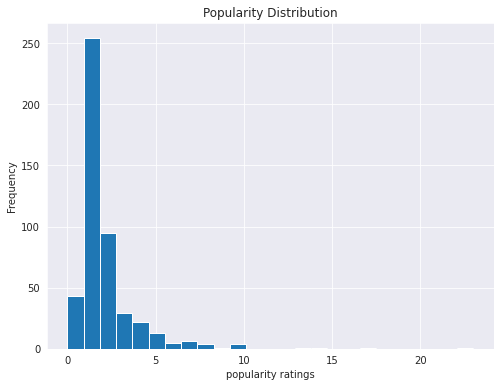

In [8]:
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
popularity_mean_count['popularity_count'].hist(bins=25)
plt.ylabel('Frequency')
plt.xlabel('popularity ratings')
plt.title('Popularity Distribution')

This shows that the majority of the songs have been searched less than 5 times, resulting in a popularity score that is leaning towards the lower end.

<Figure size 576x432 with 0 Axes>

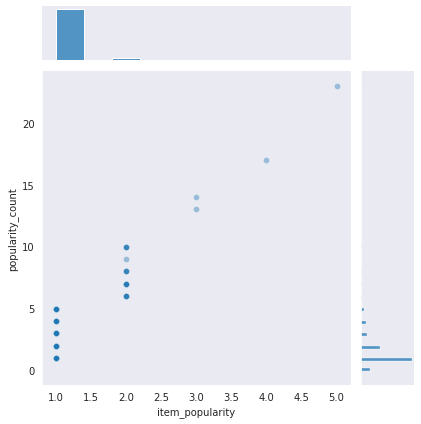

In [9]:
plt.figure(figsize=(8,6))

plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='item_popularity', y='popularity_count', data=popularity_mean_count, alpha=0.4)

This just shows that lower item count has a lower item popularity. This is true since the popularity is calculated based on the frequency of item searched.

In [10]:
df_02 = df_01[['user_id','item_id','item_popularity','event_timestamp','item_name']]
df_02 = df_02.pivot_table(index='user_id', columns='item_name', values='item_popularity')
df_02.head(2)

item_name,"""Abba, Father,"" we approach Thee","""All in His hands""—what confidence it brings","""Great is Thy faithfulness,"" O God my Father",'Tis so sweet to trust in Jesus,"Abba, Father! we adore Thee","Abide in Me, and I in you",All I have in Adam is but sin and death,All hail the pow'r of Jesus' name!,All my life long I had panted,"All that we were—our sin, our guilt","Amazing words!—He 'gave Himself for me,'",And can it be that I should gain,And is it so! I shall be like Thy Son?,As we're sharing of the cup,"Be Thou my vision, O Lord of my heart","Be Thou supreme, O Jesus Christ",Before the throne of God above,Begin the day with God!,Behold the Lamb with glory crowned,"Bit by bit, day by day, His dear words of grace","Blessed assurance, Jesus is mine",Blessing and honor and glory be Thine,"Blest Father of glory, we worship:",Break Thou the Bread of Life,"Breathe Thou, O Lord, on me","Buried with Christ, and raised with Him too",Chosen by God in ages past,Christ delivered me when bound,Christ has a full redemption made:,Christ is risen! Hallelujah!,Christ is the mystery of God,Christ is the one reality of all,Christ to me is so subjective,Christ to minister is service,"Christian, seek not yet repose","Come into my heart, O Lord Jesus",Come let us speak till the kingdom of the Lord comes down,"Come, Thou Almighty King","Come, Thou Fount of every blessing","Come, let us all unite to sing",...,Unto him that hath Thou givest,"Watch, be ready",We are never weary singing our eternal song:,"We bless Thee, God and Father","We bow and worship, Father, here",We have a most glorious King,We have found the Christ who's all in all,We have oil in our lamps—we are burning!,We praise Thee for Thy righteousness,"We praise Thee, O God","We praise Thee, glorious Father","We're gathered here, O Lord, as Thy one Body:",We're renewed and revived by the Lord day by day,We've found the secret of living,What a happy day,What about my sinful past?,What caused Mary to give her all?,What love Thou hast bestowed on us,"What mystery, the Father, Son, and Spirit",What release the Savior gave me!,"What shall I give Thee, Master?",What things were gains to me,"What we are, we're His image","When I grow up, I want to be a man of God.",When I'm with the saints,When I've run the race before me,When all around my sky is falling,When morning gilds the skies,When peace like a river attendeth my way,When this passing world is done,When this poor sinner stands at last,When thou wakest in the morning,"Where have you laid Him, my Jesus?",While fighting for my Savior here,Who can ever know the feeling deep down in my heart,Who is He in yonder stall,Who is on the Lord's side?,"Why should I worry, doubt and fear?",Will you be an overcomer?,"You have longed for sweet peace, and for faith to increase"
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Picked a random item, in this case I chose the first item_name
aa = df_02.corrwith(df_02['Glory be to God the Father'])
corr_item01 = pd.DataFrame(aa, columns=['Correlation'])
corr_item01.sort_values('Correlation', ascending=False).head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
item_name,
"""Abba, Father,"" we approach Thee",NaN
"""All in His hands""—what confidence it brings",NaN
"""Great is Thy faithfulness,"" O God my Father",NaN
'Tis so sweet to trust in Jesus,NaN
"Abba, Father! we adore Thee",NaN


Need to add popularity count to decrease bias from a high popularity but low popularity count

In [12]:
corr_item01 = corr_item01.join(popularity_mean_count['popularity_count'])
corr_item01[corr_item01['popularity_count']>1].sort_values('Correlation', ascending=False).head()
# This accounts for correlations based on firstly the popularity score followed by the popularity count

,Correlation,popularity_count
item_name,,
"""Great is Thy faithfulness,"" O God my Father",NaN,2
"Abide in Me, and I in you",NaN,2
All I have in Adam is but sin and death,NaN,2
All hail the pow'r of Jesus' name!,NaN,3
All my life long I had panted,NaN,10


This is a simple recommendation system that can be implemented using the popularity of items between users to evaluate correlation. At this point in time there is not enough data (only consists of 2 days of data). Thus, this results shown are not accurate.

### Recommendation System Metrics 02 - Euclidean Distance Method

In [13]:
df_01.head(1)

,user_pseudo_id,event_timestamp,item_name,item_category,item_subcategory,user_id,item_id,item_cat_id,item_subcat_id,item_count,item_popularity
14,cb052c8ce7b261aecf783ce043089fb3,2020-11-07 21:48:24.848002,"One with Thee, Thou Son eternal",Union with Christ,One with Him,324,338,23,161,1,1


In [14]:
from sklearn.preprocessing import OneHotEncoder
from math import pow, sqrt

# Dummies approach Encoding item_category
df_cat = df_01[['item_category']].dropna()
df_cat = df_cat.join(pd.get_dummies(df_cat, columns=["item_category"], prefix=['Cat']))
df_cat.drop('item_category', axis=1, inplace=True)

# OneHotEncoding method
df_items = df_01[['item_id','item_name']].dropna()
df_items = df_items.join(df_cat)
#df_items = df_items.join(pd.DataFrame(OneHotEncoder(handle_unknown='ignore').fit_transform(df_items[['item_category']]).toarray()))
df_items.head(2)

,item_id,item_name,Cat_Assurance and Joy of Salvation,Cat_Blessing of the Trinity,Cat_Comfort in Trials,Cat_Consecration,Cat_Encouragement,Cat_Experience of Christ,Cat_Experience of God,Cat_Fulness of the Spirit,Cat_Gospel,Cat_Hope of Glory,Cat_Longings,Cat_Meetings,Cat_Praise of the Lord,Cat_Prayer,Cat_Preaching of the Gospel,Cat_Scriptures for Singing,Cat_Service,Cat_Spiritual Warfare,Cat_Study of the Word,Cat_The Church,Cat_The Kingdom,Cat_The Word of God,Cat_Ultimate Manifestation,Cat_Union with Christ,Cat_Various Aspects of the Inner Life,Cat_Worship of the Father
14,338,"One with Thee, Thou Son eternal",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
37,381,Take time to behold Him,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Extract popularity rating
def get_popularity_(userid,itemid):
    return (df_01.loc[(df_01.user_id==userid) & (df_01.item_id == itemid),'item_popularity'].iloc[0])
# Extract item_id
def get_itemids_(userid):
    return (df_01.loc[(df_01.user_id==userid),'item_id'].tolist())
# Extract item_name
def get_item_name_(itemid):
    return (df_items.loc[(df_items.item_id == itemid),'item_name'].iloc[0])

In [16]:
def distance_similarity_score(user1,user2):
    # Empty list to contain items called by both users
    item_count = 0
    for i in df_01.loc[df_01.user_id==user1,'item_id'].tolist():
        if i in df_01.loc[df_01.user_id==user2,'item_id'].tolist():
            item_count += 1
    if item_count == 0 :
        return 0
    
    # Euclidean distance between 2 users
    distance = []
    for i in df_01.loc[df_01.user_id==user1,'item_id'].tolist():
        if i in df_01.loc[df_01.user_id==user2,'item_id'].tolist():
            rating1 = get_popularity_(user1,i)
            rating2 = get_popularity_(user2,i)
            distance.append(pow(rating1 - rating2, 2))
    total_distance = sum(distance)
    
    # Handling 'Divide by Zero' error
    return 1/(1+sqrt(total_distance))

In [17]:
Euclidean_dist = []
for i in range(904):
  dist = distance_similarity_score(i,904)
  Euclidean_dist.append(dist)
  #print('Euclidean distance between user_id {}'.format(i) + ' & 100: {}'.format(a))
set(Euclidean_dist)

{0}

This value output above shows that there is no relationship whatsover between search categories of users. This is to be expected as there is the need for more data to show any kind of correlation.

### Recommendation System Metrics 03 - Pearson_correlation Method

In [18]:
def pearson_correlation_score(user1,user2):
    # Empty list to contain items called by both users
    item_count = []
    
    # Finding items searched by both the users
    for i in df_01.loc[df_01.user_id==user1,'item_id'].tolist():
        if i in df_01.loc[df_01.user_id==user2,'item_id'].tolist():
            item_count.append(i)
    
    # zero correlation for common item
    if len(item_count) == 0 :
        return 0
    
    # Calculating Co-Variances.
    rating_sum1 = sum([get_popularity_(user1,i) for i in item_count])
    rating_sum2 = sum([get_popularity_(user2,i) for i in item_count])
    rating_squared_sum1 = sum([pow(get_popularity_(user1,i),2) for i in item_count])
    rating_squared_sum2 = sum([pow(get_popularity_(user2,i),2) for i in item_count])
    product_sum_rating = sum([get_popularity_(user1,i) * get_popularity_(user2,i) for i in item_count])
    
    # Returning pearson correlation between both the users
    numerator = product_sum_rating - ((rating_sum1 * rating_sum2) / len(item_count))
    denominator = sqrt((rating_squared_sum1 - pow(rating_sum1,2) / len(item_count)) * (rating_squared_sum2 - pow(rating_sum2,2) / len(item_count)))
    
    # Handling 'Divide by Zero' error
    if denominator == 0:
        return 0
    return numerator/denominator

In [19]:
Pearson_corr = []
for i in range(904):
  p_corr = pearson_correlation_score(i,904)
  Pearson_corr.append(p_corr)
set(Pearson_corr)

{0}

Similar to the previous methods, there is insufficient data to showcase any kind of correlation between users search features.

### User Similarity Function based on pearson

In [20]:
# Function to find other users similar to chosen user
def most_similar_users_(user1,number_of_users,metric='pearson'):
    # Getting distinct user_id
    user_ids = df_01.user_id.unique().tolist()
    
    # Comparing similarity score between all combinations of users
    if(metric == 'pearson'):
        similarity_score = [(pearson_correlation_score(user1,nth_user),nth_user) for nth_user in user_ids[:100] if nth_user != user1]
    else:
        similarity_score = [(distance_similarity_score(user1,nth_user),nth_user) for nth_user in user_ids[:100] if nth_user != user1]
    
    # Sorting in descending order
    similarity_score.sort()
    similarity_score.reverse()
    
    # Display highest similarity score users
    return similarity_score[:number_of_users]
# List the top 5 most similar users to user 1
print(most_similar_users_(1,5))

[(0, 334), (0, 333), (0, 329), (0, 327), (0, 324)]


### Recommendation System

In [21]:
def get_recommendation_(userid):
    user_id = df_01.user_id.unique().tolist()
    total = {}
    similariy_sum = {}
    
    # Iterating over subset of user_id
    for user in user_id[:100]:
        
        # Avoid comparison to same user_id
        if user == userid:
            continue
        
        # Similarity score between the users
        score = pearson_correlation_score(userid,user)
        
        # Bypass users with zero similarity score
        if score <= 0:
            continue
        
        # Weighted similarity score and sum of similarities between both users
        for item_id in get_itemids_(user):
            # Only considering not searched/rated items
            if item_id not in get_itemids_(userid) or get_popularity_(userid,item_id) == 0:
                total[item_id] = 0
                total[item_id] += get_popularity_(user,item_id) * score
                similariy_sum[item_id] = 0
                similariy_sum[item_id] += score
    
    # Normalizing ratings
    ranking = [(tot/similariy_sum[item_id],item_id) for item_id,tot in total.items()]
    ranking.sort()
    ranking.reverse()
    
    # Matching Item_name to item_id
    recommendations = [get_item_name_(item_id) for score,item_id in ranking]
    return recommendations[:10]

In [22]:
Recommendation = []
for i in range(5):
  rec = get_recommendation_(i)
  print('Recommendations for user_id {}'.format(i) + ' is: {}'.format(rec))

Recommendations for user_id 0 is: []
Recommendations for user_id 1 is: []
Recommendations for user_id 2 is: []
Recommendations for user_id 3 is: []
Recommendations for user_id 4 is: []


When more data are available, I will try out a more elegant method for implementing a search recommendation.